# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.658181,True,3.797700
1,-0.964916,True,4.221896
2,-1.149944,False,0.729126
3,-1.390491,False,1.187985
4,0.720755,False,-0.689576
...,...,...,...
995,-0.074360,True,3.217280
996,0.460950,True,3.959319
997,-0.625575,True,5.542411
998,0.597749,False,-0.124861


<AxesSubplot: xlabel='v0'>

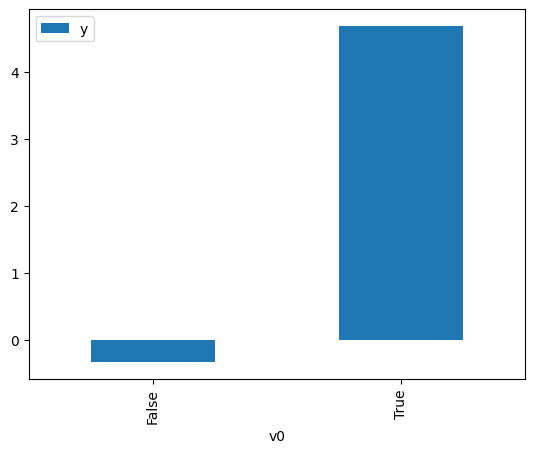

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

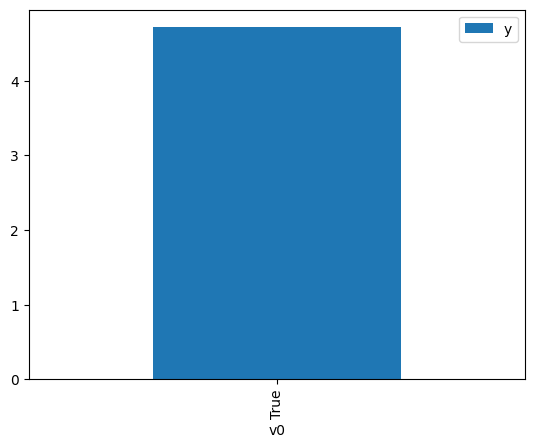

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.078120,False,-0.753277,0.643623,1.553705
1,0.297945,False,-1.508281,0.455125,2.197199
2,-0.398438,False,0.424240,0.552369,1.810382
3,-0.726278,False,-0.668687,0.597236,1.674380
4,-1.713187,False,-0.996911,0.720511,1.387904
...,...,...,...,...,...
995,-0.872171,False,-0.606667,0.616736,1.621440
996,-2.053883,False,-1.123060,0.757296,1.320487
997,-1.020677,False,-0.534842,0.636206,1.571818
998,-1.173023,False,0.109275,0.655726,1.525027


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.625575,True,5.542411,0.416410,2.401482
1,0.447339,True,6.969588,0.565546,1.768204
2,-0.197379,True,3.499899,0.475624,2.102501
3,-0.665444,True,2.137374,0.410991,2.433145
4,-1.358920,True,3.581270,0.321153,3.113777
...,...,...,...,...,...
995,0.123778,True,4.624038,0.520585,1.920916
996,-0.703583,True,4.944342,0.405827,2.464105
997,-1.182729,True,4.844617,0.343047,2.915050
998,-0.048584,True,4.003350,0.496450,2.014302


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              5771.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        08:06:02   Log-Likelihood:                         -1392.9
No. Observations:                1000   AIC:                                      2790.
Df Residuals:                     998   BIC:                                      2800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5926      0.027     22.121      0.000       0.540       0.645
x2             5.0101      0.047    106.892      0.000       4.918       5.102
==============================================================================
Omnibus:                        2.078   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.935
Skew:                          -0.091   Prob(JB):                        0.380
Kurtosis:                       3.115   Cond. No.                         1.77
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""